# Predicting House Prices on Kaggle

:label:`chapter_kaggle_house`


In the previous sections, we introduced
the basic tools for building deep networks
and performing capacity control via
dimensionality-reduction, weight decay and dropout.
You are now ready to put all this knowledge into practice
by participating in a Kaggle competition.
[Predicting house prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) is a great place to start:
the data is reasonably generic and doesn't have
the kind of rigid structure that might require specialized models
the way images or audio might.
This dataset, collected by [Bart de Cock](http://jse.amstat.org/v19n3/decock.pdf) in 2011, is considerably larger than the famous the [Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names) of Harrison and Rubinfeld (1978).
It boasts both more examples and more features,
covering house prices in Ames, IA from the period of 2006-2010.


In this section, we will walk you through details of data preprocessing,
model design, hyperparameter selection and tuning.
We hope that through a hands-on approach,
you will be able to observe the effects of capacity control,
feature extraction, etc. in practice.
This experience is vital to gaining intuition as a data scientist.

## Kaggle

[Kaggle](https://www.kaggle.com) is a popular platform
for machine learning competitions.
It combines data, code and users in a way to allow
for both collaboration and competition.
While leaderboard chasing can sometimes get out of control,
there's also a lot to be said for the objectivity in a platform
that provides fair and direct quantitative comparisons
between your approaches and those devised by your competitors.
Moreover, you can checkout the code
from (some) other competitors' submissions
and pick apart their methods to learn new techniques.
If you want to participate in one of the competitions,
you need to register for an account (do this now!).



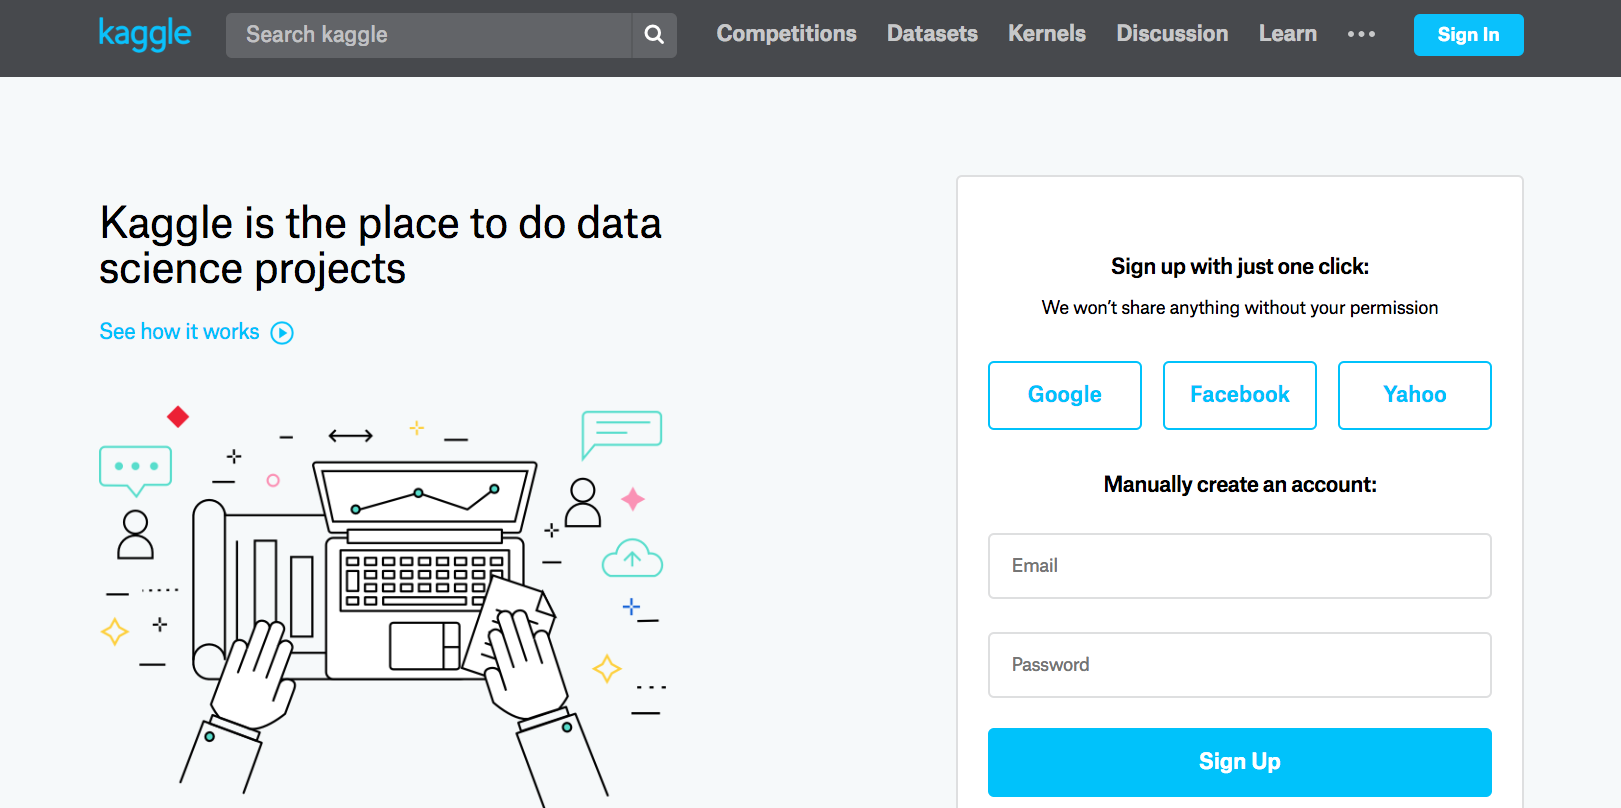

In [11]:
from IPython.display import Image
Image(filename="../img/kaggle.png")
#Kaggle Website

On the House Prices Prediction page,
you can find the data set (under the data tab),
submit predictions, see your ranking, etc.,
The URL is right here:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques


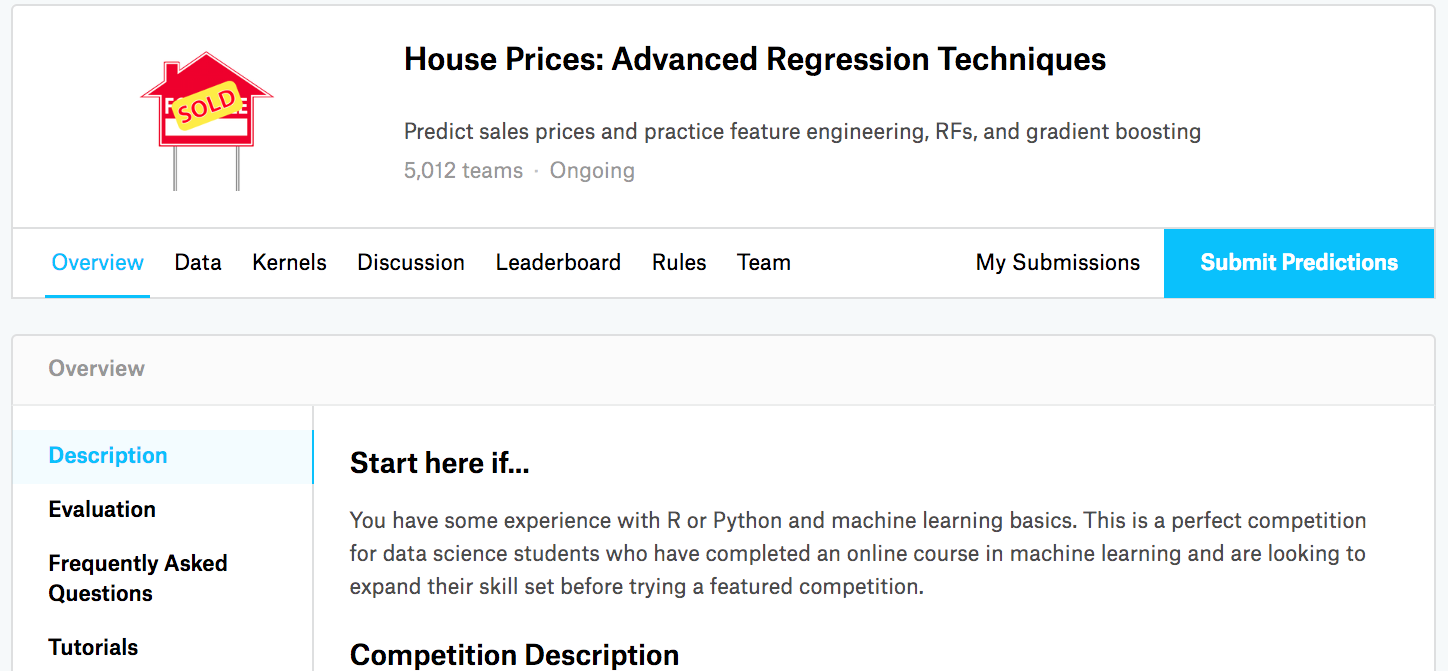

In [12]:
Image(filename="../img/house_pricing.png")
#House Price Prediction

## Accessing and Reading Data Sets

Note that the competition data is separated into training and test sets.
Each record includes the property value of the house
and attributes such as street type, year of construction,
roof type, basement condition, etc.
The features represent multiple datatypes.
Year of construction, for example, is represented with integers
roof type is a discrete categorical feature,
other features are represented with floating point numbers.
And here is where reality comes in:
for some exampels, some data is altogether missing
with the missing value marked simply as 'na'.
The price of each house is included for the training set only
(it's a competition after all).
You can partition the training set to create a validation set,
but you'll only find out how you perform on the official test set
when you upload your predictions and receive your score.
The 'Data' tab on the competition tab has links to download the data.

We will read and process the data using `pandas`,
an [efficient data analysis toolkit](http://pandas.pydata.org/pandas-docs/stable/), so you will want to make sure that you have `pandas` installed
before proceeding further. Fortunately, if you're reading in Jupyter,
we can install pandas without even leaving the notebook.

In [13]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

import sys
sys.path.insert(0, '..')

%matplotlib inline
import torch
import torch.utils.data
import torch.nn as nn
import d2l

import numpy as np
import pandas as pd

For convenience, we already downloaded the data
and stored it in the `../data` directory.
To load the two CSV (Comma Separated Values) files
containing training and test data respectively we use Pandas.

In [14]:
train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv')

The training data set includes 1,460 examples, 80 features, and 1 label.,
the test data contains 1,459 examples and 80 features.

In [15]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let’s take a look at the first 4 and last 2 features
as well as the label (SalePrice) from the first 4 examples:

In [16]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


We can see that in each example, the first feature is the ID.
This helps the model identify each training example.
While this is convenient, it doesn't carry
any information for prediction purposes.
Hence we remove it from the dataset before feeding the data into the network.

In [17]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Data Preprocessing

As stated above, we have a wide variety of datatypes.
Before we feed it into a deep network,
we need to perform some amount of processing.
Let's start with the numerical features.
We begin by replacing missing values with the mean.
This is a reasonable strategy if features are missing at random.
To adjust them to a common scale,
we rescale them to zero mean and unit variance.
This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}$$

To check that this transforms $x$ to data
with zero mean and unit variance simply calculate
$\mathbf{E}[(x-\mu)/\sigma] = (\mu - \mu)/\sigma = 0$.
To check the variance we use $\mathbf{E}[(x-\mu)^2] = \sigma^2$
and thus the transformed variable has unit variance.
The reason for 'normalizing' the data is that
it brings all features to the same order of magnitude.
After all, we do not know *a priori*
which features are likely to be relevant.

In [18]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Next we deal with discrete values.
This includes variables such as 'MSZoning'.
We replace them by a one-hot encoding
in the same manner as how we transformed multiclass classification data
into a vector of $0$ and $1$.
For instance, 'MSZoning' assumes the values 'RL' and 'RM'.
They map into vectors $(1,0)$ and $(0,1)$ respectively.
Pandas does this automatically for us.

In [19]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

You can see that this conversion increases the number of features
from 79 to 331.
Finally, via the `values` attribute,
 we can extract the NumPy format from the Pandas dataframe
 and convert it into torch tensor representation for training.

In [20]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values.astype(np.float32))
test_features = torch.tensor(all_features[n_train:].values.astype(np.float32))
train_labels = torch.tensor(train_data.SalePrice.values.astype(np.float32)).reshape((-1, 1))

## Training

To get started we train a linear model with squared loss.
Not surprisingly, our linear model will not lead
to a competition winning submission
but it provides a sanity check to see whether
there's meaningful information in the data.
If we can't do better than random guessing here,
then there might be a good chance
that we have a data processing bug.
And if things work, the linear model will serve as a baseline
giving us some intuition about how close the simple model
gets to the best reported models, giving us a sense
of how much gain we should expect from fanicer models.

In [21]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

With house prices, as with stock prices, we care about relative quantities more than absolute quantities.
More concretely, we tend to care more
about the relative error $\frac{y - \hat{y}}{y}$
than about the absolute error $y - \hat{y}$.
For instance, if our prediction is off by USD 100,000
when estimating the price of a house in Rural Ohio,
where the value of a typical house is 125,000 USD,
then we are probably doing a horrible job.
On the other hand, if we err by this amount in Los Altos Hills, California,
this might represent a stunningly accurate prediction
(their, the median house price exceeds 4 million USD).

One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.
In fact, this is also the official error metric
used by the compeitition to measure the quality of submissions.
After all, a small value $\delta$ of $\log y - \log \hat{y}$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

In [22]:
def log_rmse(net,features,labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt( torch.mean(loss(torch.log(clipped_preds),torch.log(labels))))
    return rmse.item()

Unlike in previous sections, our training functions here
will rely on the Adam optimizer
(a slight variant on SGD that we will describe in greater detail later).
The main appeal of Adam vs vanilla SGD is that
the Adam optimizer, despite doing no better (and sometimes worse)
given unlimited resources for hyperparameter optimization,
people tend to find that it is significantly less sensitive
to the initial learning rate.
This will be covered in further detail later on
when we discuss the details in :numref:`chapter_optimization`.

In [23]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features,train_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),lr= learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            outputs = net(X)
            l = loss(outputs,y) 
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## k-Fold Cross-Validation

If you are reading in a linear fashion,
you might recall that we intorduced k-fold cross-validation
in the section where we discussed how to deal
with model section (:numref:`chapter_model_selection`). We will put this to good use to select the model design
and to adjust the hyperparameters.
We first need a function that returns
the i-th fold of the data in a k-fold cros-validation procedure.
It proceeds by slicing out the i-th segment as validation data
and returning the rest as training data.
Note that this is not the most efficient way of handling data
and we would definitely do something much smarter
if our dataset was considerably larger.
But this added complexity might obfuscate our code unnecessarily
so we can safely omit here owing to the simplicity of our problem.

In [24]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned
when we train $k$ times in the k-fold cross-validation.

In [25]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## Model Selection

In this example, we pick an un-tuned set of hyperparameters
and leave it up to the reader to improve the model.
Finding a good choice can take quite some time,
depending on how many things one wants to optimize over.
Within reason, the k-fold cross-validation approach
is resilient against multiple testing.
However, if we were to try out an unreasonably large number of options
it might fail since we might just get lucky
on the validation split with a particular set of hyperparameters.

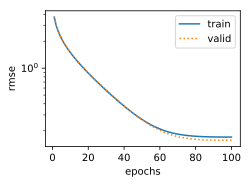

fold 0, train rmse: 0.169580, valid rmse: 0.156457
fold 1, train rmse: 0.162256, valid rmse: 0.188862
fold 2, train rmse: 0.163859, valid rmse: 0.168451
fold 3, train rmse: 0.167941, valid rmse: 0.154711
fold 4, train rmse: 0.163324, valid rmse: 0.182826
5-fold validation: avg train rmse: 0.165392, avg valid rmse: 0.170261


In [26]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

You will notice that sometimes the number of training errors
for a set of hyper-parameters can be very low,
while the number of errors for the $K$-fold cross-validation may be higher. This is an indicator that we are overfitting.
Therefore, when we reduce the amount of training errors,
we need to check whether the amount of errors
in the k-fold cross-validation have also been reduced accordingly.

##  Predict and Submit

Now that we know what a good choice of hyperparameters should be,
we might as well use all the data to train on it
(rather than just $1-1/k$ of the data
that is used in the crossvalidation slices).
The model that we obtain in this way
can then be applied to the test set.
Saving the estimates in a CSV file
will simplify uploading the results to Kaggle.

In [27]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Let's invoke our model.
One nice sanity check is to see
whether the predictions on the test set
resemble those of the k-fold cross-validation process.
If they do, it's time to upload them to Kaggle.
The following code will generate a file called `submission.csv`
(CSV is one of the file formats accepted by Kaggle):

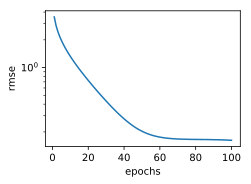

train rmse 0.162384


In [28]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

Next, we can submit our predictions on Kaggle
and see how they compare to the actual house prices (labels) on the test set.
The steps are quite simple:

* Log in to the Kaggle website and visit the House Price Prediction Competition page.
* Click the “Submit Predictions” or “Late Submission” button (as of this writing, the button is located on the right).
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.



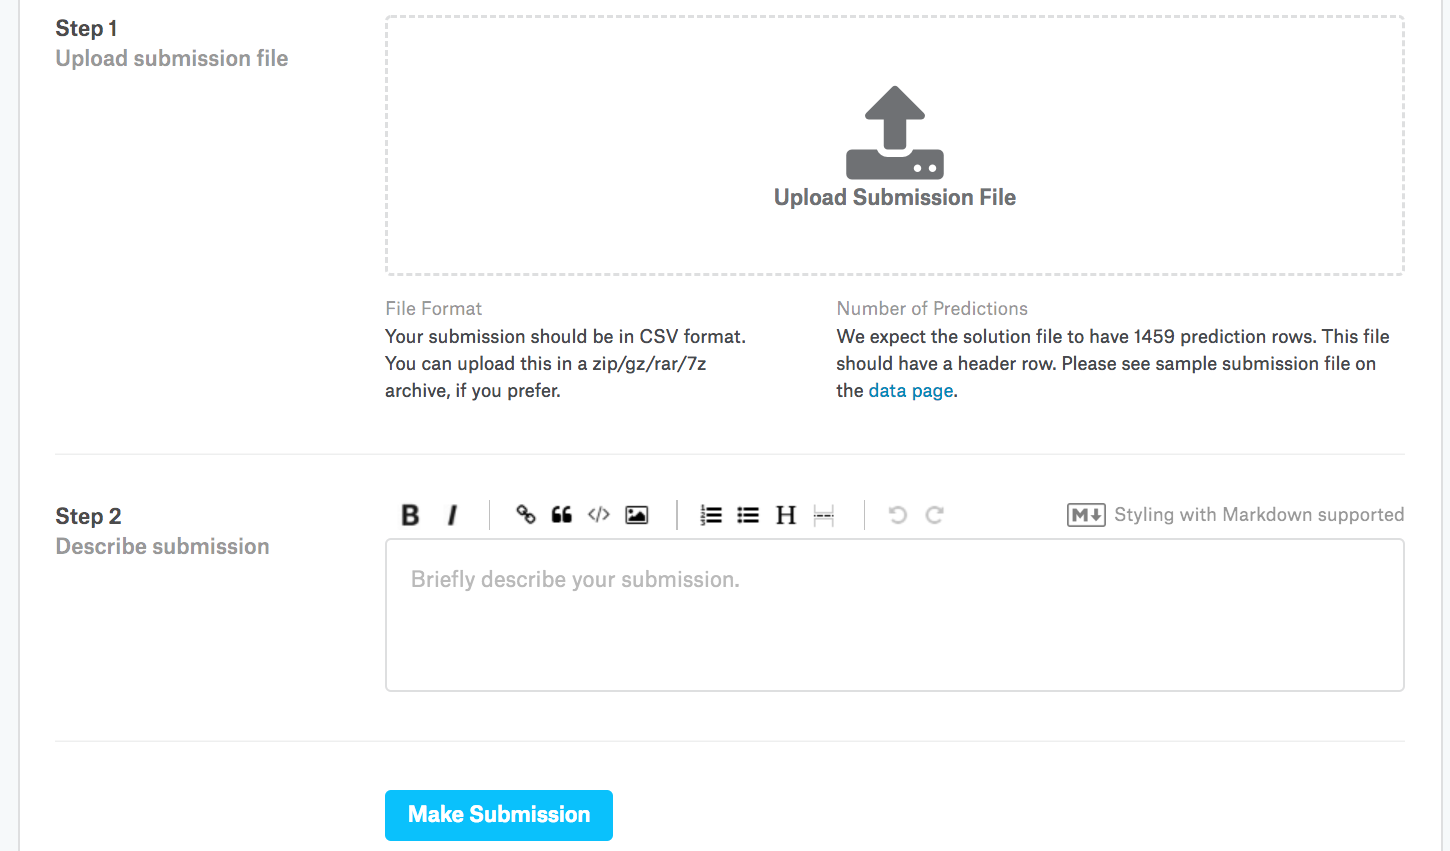

In [29]:
Image(filename="../img/kaggle_submit2.png")
#Submitting data to Kaggle

## Summary

* Real data often contains a mix of different datatypes and needs to be preprocessed.
* Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.
* Transforming categorical variables into indicator variables allows us to treat them like vectors.
* We can use k-fold cross validation to select the model and adjust the hyper-parameters.
* Logarithms are useful for relative loss.


## Exercises

1. Submit your predictions for this tutorial to Kaggle. How good are your predictions?
1. Can you improve your model by minimizing the log-price directly? What happens if you try to predict the log price rather than the price?
1. Is it always a good idea to replace missing values by their mean? Hint - can you construct a situation where the values are not missing at random?
1. Find a better representation to deal with missing values. Hint - What happens if you add an indicator variable?
1. Improve the score on Kaggle by tuning the hyperparameters through k-fold crossvalidation.
1. Improve the score by improving the model (layers, regularization, dropout).
1. What happens if we do not standardize the continuous numerical features like we have done in this section?